<h1 align="center">Problem - Building an HBM</h1>
<h2 align="center">One- and Two-Component Gaussian Mixture Hierarchcial Bayesian Modeling with Pyjags</h2>
<h3 align="center">Simulating the eccentricity distribution of hot Jupiter exoplanets from the Kepler Mission</h3> 
<h4 align="center">LSSTC DSFP Session 4, September 21st, 2017</h4>
<h5 align="center">Author: Megan I. Shabram, PhD, 
NASA Postdoctoral Program Fellow,  mshabram@gmail.com</h5>


In this Hierachical Bayesian Model exercise, we will be using truncated normal distributions where using MCMC to numerically compute posterior distributions is effective. The simulated data sets generated below are modeled after the projected eccentricity obtained for exoplanet systems that both transit and occult their host star (see Shabram et al. 2016) 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyjags
import pickle

from __future__ import division, print_function
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
#plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%qtconsole


<h3 align="left"> 1. Generate simulated data set: one-component Gaussian mixture generative model:</h3>


<div><p>Eccentricity cannot be greater than 1 physically (or it means an unbound orbit and
that is not the case for planet observed to both transit and occult more than once).
This creates a situation where the distributions must be truncated, rendering the 
problem unable to be calculated analytically, and requaring numerical methods such
the MCMC sampler used below, jags, called with pyjags.</p><div>

In [3]:
## function to draw from truncated normal, this function will be used for both the 
## one- and two-componenet cases in this workbook.  

def rnorm_bound( Ndata, mu, prec, lower_bound = 0.0, upper_bound = float('Inf')):
    x = np.zeros(Ndata)
    #print(x)
    for i in range(0, Ndata): 
            #print(i)
            while True:
                x[i] = np.random.normal(mu,prec,1)
                if( (x[i]>lower_bound) and (x[i]<upper_bound) ): 
                    break
    return x;

In [4]:
## Check the output to make sure the function is outputting as expected. 
#print(np.random.normal(0,0.0001,10))
print(rnorm_bound(10, 0.0, 0.001, lower_bound=-1,upper_bound=1))

[  7.15187577e-04  -6.33277693e-04   2.26240202e-05  -2.33863991e-04
   1.26988494e-03  -4.57631140e-04  -7.08623177e-05  -7.76963659e-04
   7.86765874e-04   1.10903114e-03]


[ 0.32591634  0.44313514  0.25502229  0.59272619  0.11318514 -0.5160644
 -0.17330448 -0.50696964 -0.15105711 -0.09165591  0.49521297 -0.08182615
 -0.10580818  0.25930761  0.29216831  0.39718152 -0.03807849  0.35398702
  0.14419527 -0.04722889  0.00953419 -0.55438116 -0.11613886  0.24042083
  0.15835371 -0.41890935  0.224293    0.5692061  -0.04025721 -0.23954698
 -0.02939725  0.46843491 -0.5067681  -0.57787355  0.28820561  0.12444914
 -0.15857133  0.28782725  0.25506787  0.25762319  0.40479387  0.37745105
  0.08334606 -0.19580431  0.30304231  0.19323961 -0.06293652  0.12402948
 -0.88319763 -0.10401672] [ 0.34290341  0.46601264  0.25265937  0.62568577  0.1808711  -0.44707726
 -0.23394208 -0.49429803 -0.18266701 -0.04214974  0.50799726 -0.10571866
 -0.10843491  0.21708732  0.29229058  0.44127119 -0.0275646   0.37165116
  0.22053189 -0.0056877   0.01651881 -0.57489087 -0.09483164  0.2597074
  0.17875498 -0.47079471  0.2649382   0.59030032 -0.0771801  -0.17558353
 -0.07665916  0.3642057  -0

(array([  1.,   0.,   6.,   0.,   5.,  11.,   3.,  13.,   8.,   3.]),
 array([-0.89447387, -0.7424579 , -0.59044194, -0.43842598, -0.28641001,
        -0.13439405,  0.01762191,  0.16963788,  0.32165384,  0.4736698 ,
         0.62568577]),
 <a list of 10 Patch objects>)

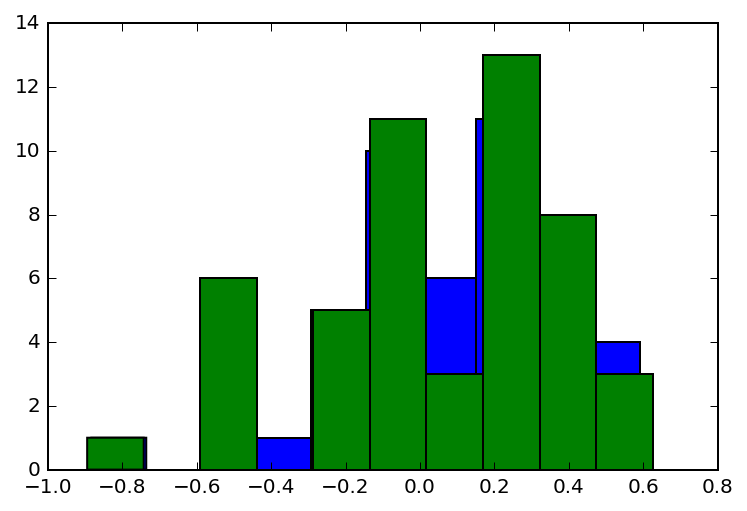

In [5]:
## one-component Gaussian Mixture Simulated Data

## In this simulated data set, their are 50 planetary systems (with one planet each)
Ndata = 50 
## Here we asign the dispersion of the simulated population to be 0.3, this is 
## the truth we wish to recovern 
sigmae = 0.3 
## We approximate the uncertainty for each measurement as normally distributed about a 
## reporte measurement point estimate.  For the eccentricity distribution for Hot Jupiter
## the physical models used to derive these produce larger uncertainty in k by a factor of 2. 
sigmahobs = 0.04
sigmakobs = 0.08

h = np.repeat(0.,Ndata)
k = np.repeat(0.,Ndata)
hhat = np.repeat(0.,Ndata)
khat = np.repeat(0.,Ndata)
hhat_sigma  = np.repeat(sigmahobs,Ndata)
khat_sigma  = np.repeat(sigmakobs,Ndata)

#print(khat_sigma)


for i in range(0,Ndata):
    h[i] = rnorm_bound(1,0,sigmae,lower_bound=-1,upper_bound=1)
    lb = -np.sqrt(1-h[i]**2)
    ub = np.sqrt(1-h[i]**2)
    k[i] = rnorm_bound(1,0,sigmae,lower_bound=lb,upper_bound=ub) 
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)
    khat[i] = rnorm_bound(1,k[i],sigmakobs,lower_bound=lb,upper_bound=ub)

## Vizualize the true data values, and the simulated measurements:     
print(h, hhat, k, khat)
plt.hist(h)
plt.hist(hhat)

In [6]:
## JAGS user manual: 
## http://www.uvm.edu/~bbeckage/Teaching/DataAnalysis/Manuals/manual.jags.pdf

## JAGS model code

code = '''

model {
        
    #Population parameters
    e_sigma ~ dunif(0.0, 1.0)
    e_phi <- 1/(e_sigma*e_sigma)
        
    for (n in 1:Ndata){
    
        #True planet properties
        h[n] ~ dnorm(0, e_phi) T(-1,1) #Can try multivariate truncated normal in future
        k[n] ~ dnorm(0, e_phi) T(-sqrt(1-h[n]*h[n]),sqrt(1-h[n]*h[n]))
            
        #Observed planet properties
        hhat[n] ~ dnorm(h[n], 1.0/(hhat_sigma[n]*hhat_sigma[n])) T(-1,1)
        khat[n] ~ dnorm(k[n], 1.0/(khat_sigma[n]*khat_sigma[n])) T(-sqrt(1-hhat[n]*hhat[n]),sqrt(1-hhat[n]*hhat[n]))
    }
        
}
'''

In [7]:
## Load additional JAGS module
pyjags.load_module('glm')
pyjags.load_module('dic')


## See blog post for origination of the adapted analysis tools used here and below:
## https://martynplummer.wordpress.com/2016/01/11/pyjags/


## data list include only variables in the model
model = pyjags.Model(code, data=dict( Ndata=Ndata, hhat=hhat, khat=khat, 
                                     hhat_sigma=hhat_sigma, khat_sigma=khat_sigma), 
                     chains=4, adapt=1000)

## Code to speed up compute time. This feature might not be 
## well tested in pyjags at this time. 
## threads=4, chains_per_thread=1 

## 500 warmup / burn-in iterations, not used for inference.
model.sample(500, vars=[])

## Run model for desired steps, monitoring hyperparameter variables, and latent variables
## for hierarchical Bayesian model.
## Returns a dictionary with numpy array for each monitored variable.
## Shapes of returned arrays are (... shape of variable ..., iterations, chains).
## samples = model.sample(#iterations per chain here, vars=['e_sigma', 'h', 'k'])
samples = model.sample(1000, vars=['e_sigma', 'h', 'k'])

## Code to save, open and use pickled dictionary of samples:
## -- Pickle the data --
#with open('ecc_1_test.pkl', 'wb') as handle:
#   pickle.dump(samples, handle)
## -- Retrieve pickled data --
#with open('ecc_1_test.pkl', 'rb') as handle:
#   retrieved_results = pickle.load(handle)


adapting: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00


<div>
  <h4>The following notes are meant to make it easy for students to work with and adapt this notebook to future HBM science investigations:</h4>
  <p>The pyjags output is a dictionary type (above, this is asigned to the "samples" variable). Here, the keys are <i>e_sigma</i>, <i>h</i>, and <i>k</i> (from the one-component analysis model used above). Furthermore, <br />
<blockquote> e_sigma has shape (1,10000,4), <br /> 
h has shape (50,10000,4), and<br />
k has shape (50,10000,4)<br />
</blockquote>
The way to acces the latent variable marginal posteriors before updating the samples dictionary as we do below, you would use: 
<blockquote>
h1 = samples['h'][0,:,:], h2 = samples['h'][1,:,:],  ... hn = samples['h'][n,:,:] and, <br />
k1 = samples['k'][0,:,:], k2 = samples['k'][1,:,:],  ... kn = samples'k'][n,:,:] 
</blockquote>
for n population constituents. </p>

  <p>Now, we need to add keys for each latent variable into the dictionary. 
The keys we want here are are:<br /> 
<blockquote> e_sigma (the population parameter here), and<br /> 
h1, ..., h50, k1, ..., k50 for the latent variables.<br /> 
</blockquote> </p>

  <p>Our resulting dictionary elements will have the following shapes:
<blockquote> e_sigma will have shape (10000,4)<br /> 
h1 will have shape (10000,4)<br />
k1 will have shape (10000,4)<br />
.<br />
.<br />
.<br />
h50 will have shape (10000,4)<br />
k50 will have shape (10000,4),<br /> </blockquote>
for a data set with 50 population constituents. </p>
</div>

In [8]:
#print(samples)
#print(samples.items())

## Print and check the shape of the resultant samples dictionary:
print(samples['e_sigma'].shape)
print(samples['e_sigma'].squeeze(0).shape)
print(samples['h'].shape)
print(samples['k'][0,:,:].shape)
print('-----')


## Update the samples dictionary so that it includes keys for the latent variables
## Also, we will use LaTeX formatting to help make legible plots ahead.  
samples_Nm1 = {}
Nsamp=50
## We can thin the posterior distributions by adusting the thin variable below:
thin = 1
## Need to enter the number of hyperparameter variables here:
numHyperParams = 1
## Specify the dimension we want for our plot below, for legibility.  
dim = (Nsamp/thin)*2 + numHyperParams
print(dim)

for i in np.arange(0,Nsamp,thin):
    #hval = 'h'+str(i+1)
    #kval = 'k'+str(i+1)
    #print(hval)
    #print(kval)
    #samples_Nm1({hval: samples['h'][i,:,:]})
    samples_Nm1.update({'$h_{'+str(i+1)+'}$': samples['h'][i,:,:], '$k_{'+str(i+1)+'}$': samples['k'][i,:,:]})
#print(samples_2['h11'].shape)

## Add the hyperparameter marginal posterior back in:
samples_Nm1.update({'$e_{\sigma}$': samples['e_sigma'].squeeze(0)})

## Below, examine the updated and reformatted sample dictionary to include keys for 
## latent variables 
for j, i in samples_Nm1.items():
    print(j)
    print(i)
## Note: the ordering of the dictionary keys below is displayed funny below in the output, 
## but this is not an issue.

(1, 1000, 4)
(1000, 4)
(50, 1000, 4)
(1000, 4)
-----
101.0
$h_{2}$
[[ 0.41654461  0.42733415  0.4605356   0.43115807]
 [ 0.4273996   0.44080849  0.50147477  0.41783018]
 [ 0.46327161  0.48841778  0.49560642  0.41226525]
 ..., 
 [ 0.35742275  0.48027183  0.50634573  0.4808089 ]
 [ 0.49693918  0.52521192  0.48598866  0.52554129]
 [ 0.52473319  0.4046246   0.4254368   0.49786553]]
$k_{6}$
[[ 0.17669961  0.19660144  0.0546238   0.15790619]
 [ 0.20163425  0.09679924  0.0270798   0.10427634]
 [ 0.07953857  0.11512758  0.24166671  0.13672835]
 ..., 
 [ 0.08628713  0.24321989  0.12936036  0.13168857]
 [ 0.07286518  0.01993984  0.11308319  0.21533779]
 [ 0.24878125  0.25845631  0.13977906  0.06805728]]
$k_{17}$
[[ 0.45710293  0.32373405  0.47933203  0.45278696]
 [ 0.41688869  0.25598026  0.43282407  0.47053964]
 [ 0.38891609  0.5839191   0.48797241  0.41255231]
 ..., 
 [ 0.41620096  0.44150375  0.52784103  0.38547256]
 [ 0.45543456  0.40471596  0.4689317   0.52739113]
 [ 0.51044355  0.39451239 

<div>  <p>Below is code to look at <b>summary statistics</b> of <b>the marginal posterior distributions</b>  (the probabilistic parameter estimates) 
for the hyperparameter and the latent variables 
(each population constituent), in this case <i>h</i> and <i>k</i> (a.k.a projected eccentricity here), of the exoplanet systems we are simulating). </p> </div>

In [9]:
## equal tailed 95% credible intervals, and posterior distribution means:
def summary(samples, varname, p=95):
    values = samples[varname][0]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in samples_Nm1:
    summary(samples_Nm1, varname)


$h_{2}$ mean =   0.4, 95% credible interval [ 0.4  0.5]
$k_{6}$ mean =   0.1, 95% credible interval [ 0.1  0.2]
$k_{17}$ mean =   0.4, 95% credible interval [ 0.3  0.5]
$h_{14}$ mean =   0.2, 95% credible interval [ 0.1  0.3]
$k_{38}$ mean =  -0.3, 95% credible interval [-0.3 -0.3]
$h_{31}$ mean =  -0.1, 95% credible interval [-0.2 -0.1]
$k_{8}$ mean =  -0.2, 95% credible interval [-0.2 -0.2]
$k_{39}$ mean =   0.1, 95% credible interval [ 0.0  0.1]
$k_{42}$ mean =   0.3, 95% credible interval [ 0.3  0.5]
$k_{32}$ mean =   0.0, 95% credible interval [ 0.0  0.1]
$h_{19}$ mean =   0.2, 95% credible interval [ 0.2  0.2]
$k_{11}$ mean =  -0.3, 95% credible interval [-0.4 -0.2]
$e_{\sigma}$ mean =   0.3, 95% credible interval [ 0.3  0.4]
$h_{29}$ mean =  -0.1, 95% credible interval [-0.1 -0.0]
$k_{23}$ mean =  -0.0, 95% credible interval [-0.1  0.0]
$h_{16}$ mean =   0.5, 95% credible interval [ 0.4  0.5]
$k_{4}$ mean =   0.2, 95% credible interval [ 0.1  0.3]
$h_{10}$ mean =  -0.0, 95% cred

In [ ]:
# Use pandas three dimensional Panel to represent the trace:

trace = pd.Panel({k: v for k, v in samples_Nm1.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
# Point estimates:
print(trace.to_frame().mean())
 
# Bayesian equal-tailed 95% credible intervals:
print(trace.to_frame().quantile([0.05, 0.95]))
  # ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, fontsize='xx-large')
 
    # Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    # Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    # Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    # Save figure
    plt.tight_layout()
    fig.savefig('{}.png'.format(var))
 
# Display diagnostic plots
for var in trace:
    plot(trace, var)
 
# Scatter matrix plot:
scatter_matrix(trace.to_frame(),  color="darkturquoise", alpha=0.2, figsize=(dim*2, dim*2), diagonal='hist')
plt.savefig('/Users/meganshabram/Dropbox/NASA_Postdoctoral_Program_Fellowship/MRE_pyjags/plots/scatter_matrix_Nm1.png')
